#Data Loading and Inspection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import pickle


In [2]:
from google.colab import files
import io


# Dynamically ask for the dataset file
uploaded = files.upload()

# Assuming only one file is uploaded, get the filename
filename = next(iter(uploaded))

# Load the dataset
df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))
print(df.head())
print(df.info())
print(df.describe())

Saving CAR DETAILS FROM CAR DEKHO.csv to CAR DETAILS FROM CAR DEKHO.csv
                       name  year  selling_price  km_driven    fuel  \
0             Maruti 800 AC  2007          60000      70000  Petrol   
1  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
2      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
3    Datsun RediGO T Option  2017         250000      46000  Petrol   
4     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   

  seller_type transmission         owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   yea

#Data Cleaning & Preprocessing

In [3]:
# Remove duplicate rows
initial_count = df.shape[0]
df_clean = df.drop_duplicates()
print(f"Dropped {initial_count - df_clean.shape[0]} duplicate rows.")
print("Missing values per column:\n", df_clean.isnull().sum())

Dropped 763 duplicate rows.
Missing values per column:
 name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64


No Missing Values.

In [4]:
df_clean = df_clean.dropna().reset_index(drop=True)

In [5]:
# Standardize categorical columns
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']
for col in cat_cols:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.title()
df_clean

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner
...,...,...,...,...,...,...,...,...
3572,Hyundai i20 Magna 1.4 CRDi (Diesel),2014,409999,80000,Diesel,Individual,Manual,Second Owner
3573,Hyundai i20 Magna 1.4 CRDi,2014,409999,80000,Diesel,Individual,Manual,Second Owner
3574,Maruti 800 AC BSIII,2009,110000,83000,Petrol,Individual,Manual,Second Owner
3575,Hyundai Creta 1.6 CRDi SX Option,2016,865000,90000,Diesel,Individual,Manual,First Owner


#Feature Engineering

In [6]:
# Feature Engineering
CURRENT_YEAR = 2025
df_clean['car_age'] = CURRENT_YEAR - df_clean['year']
df_clean = df_clean[(df_clean['car_age'] >= 0) & (df_clean['car_age'] <= 50)].reset_index(drop=True)

# Remove outliers
price_upper_limit = df_clean['selling_price'].quantile(0.99)
df_clean = df_clean[df_clean['selling_price'] <= price_upper_limit]
km_upper_limit = df_clean['km_driven'].quantile(0.99)
df_clean = df_clean[df_clean['km_driven'] <= km_upper_limit].reset_index(drop=True)

# One-hot encoding categorical variables with drop_first to avoid dummy trap
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=False)
print(df_encoded.columns.tolist())

# Scale numerical features including target
scaler = StandardScaler()
numeric_features = ['selling_price','km_driven', 'car_age']
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])


['name', 'year', 'selling_price', 'km_driven', 'car_age', 'fuel_Cng', 'fuel_Diesel', 'fuel_Electric', 'fuel_Lpg', 'fuel_Petrol', 'seller_type_Dealer', 'seller_type_Individual', 'seller_type_Trustmark Dealer', 'transmission_Automatic', 'transmission_Manual', 'owner_First Owner', 'owner_Fourth & Above Owner', 'owner_Second Owner', 'owner_Test Drive Car', 'owner_Third Owner']


# Visualization

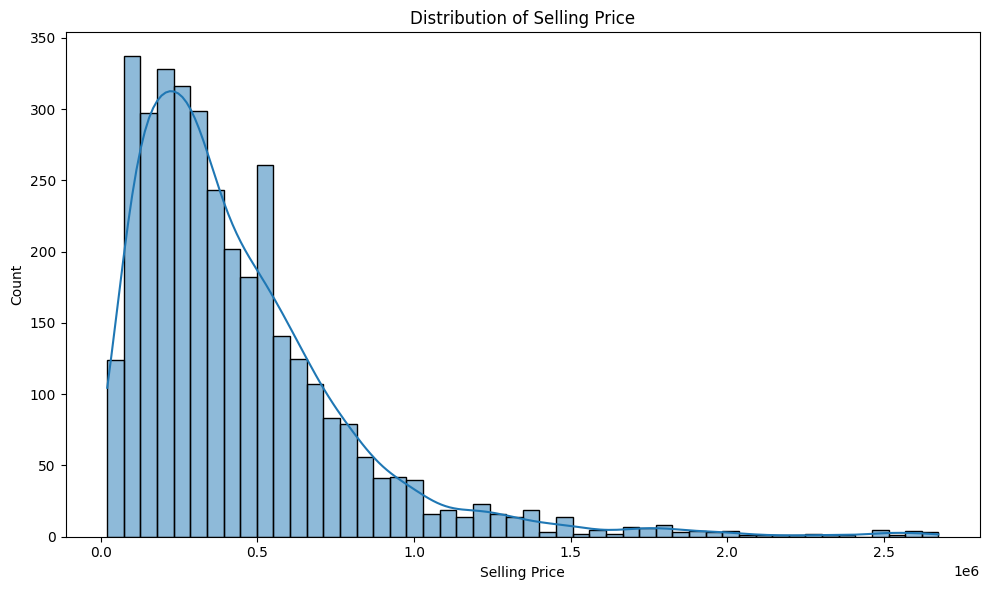

In [7]:
# 1. Distribution of Selling Price
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['selling_price'], bins=50, kde=True)
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Interpretation**

- Most cars are sold at prices below approximately 500,000 units, indicating a concentration of sales in the lower to mid-range price segment.

- The distribution is right-skewed, meaning there are fewer high-priced cars sold, but some expensive cars do exist, reaching up to around 2.5 million units or more.

- The peak around 100,000 to 300,000 units suggests that the bulk of the market demand is in affordable and mid-range cars.

- The long tail to the right reflects luxury or high-value cars, which are less common but extend the price range significantly.

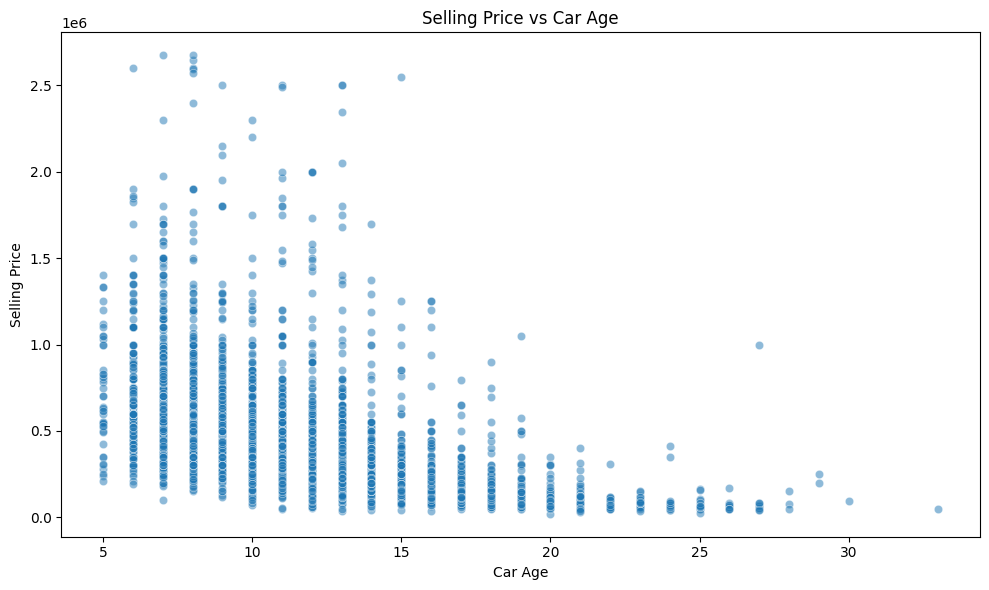

In [8]:
# 2. Selling Price vs Car Age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='car_age', y='selling_price', data=df_clean, alpha=0.5)
plt.title('Selling Price vs Car Age')
plt.xlabel('Car Age')
plt.ylabel('Selling Price')
plt.tight_layout()
plt.show()

**Insights**

- Newer cars (lower age) generally sell at higher prices, and as the car ages, prices tend to decrease significantly.

- The scatter of points shows a clear downward trend, indicating depreciation: older cars are worth less.

- There is more price variation among younger cars, with some very expensive outliers, whereas older cars have much lower and more consistent prices.

- Only a few older cars command high prices, which could represent rare, collectible, or specialty vehicles.



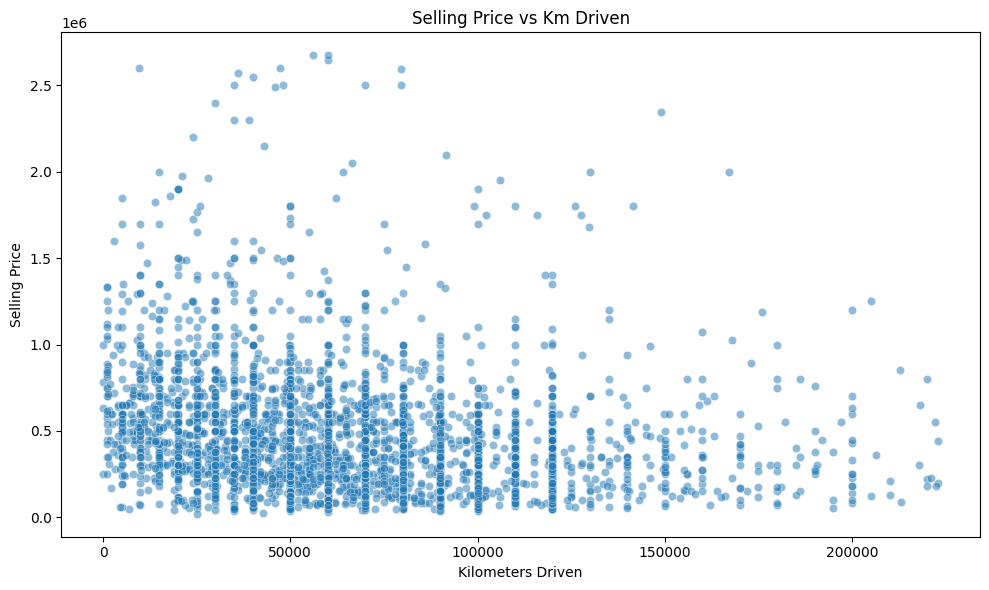

In [9]:
# 3. Selling Price vs Km Driven
plt.figure(figsize=(10, 6))
sns.scatterplot(x='km_driven', y='selling_price', data=df_clean, alpha=0.5)
plt.title('Selling Price vs Km Driven')
plt.xlabel('Kilometers Driven')
plt.ylabel('Selling Price')
plt.tight_layout()
plt.show()

**Insights**

- A general trend is visible: as the number of kilometers driven increases, the selling price tends to decrease.

- There is a wide variation in selling prices for cars with lower kilometers, with prices clustering more tightly and dropping as kilometers increase.

- High-priced sales are much rarer for vehicles with high mileage, whereas most of the cheaper cars are those with both high kilometers and possibly older models.

- Some outliers exist—cars with high kilometers but still selling for high prices, which could be due to brand, model, or unique features.



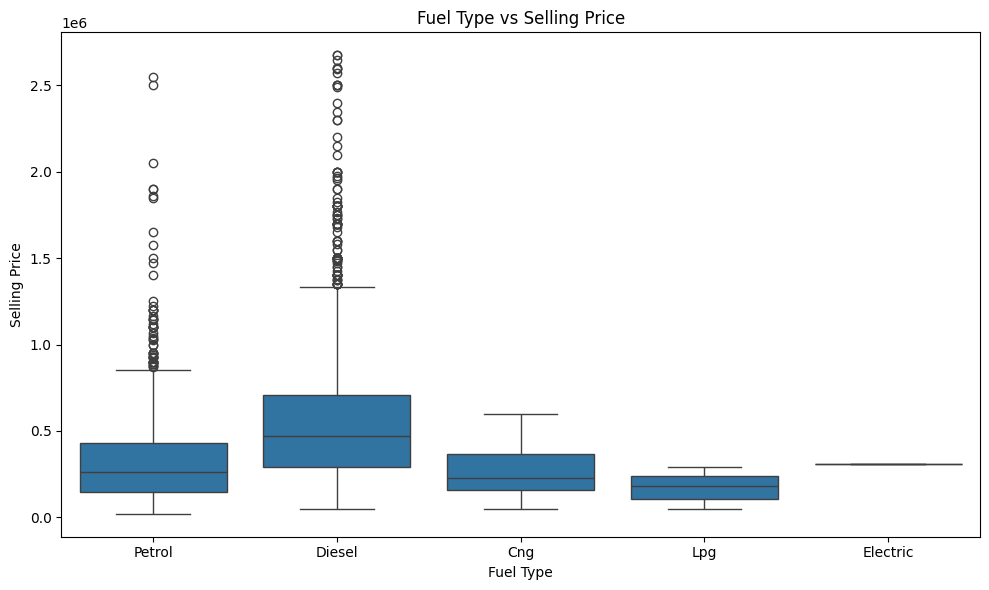

In [10]:
# 4. Fuel Type vs Selling Price (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel', y='selling_price', data=df_clean)
plt.title('Fuel Type vs Selling Price')
plt.xlabel('Fuel Type')
plt.ylabel('Selling Price')
plt.tight_layout()
plt.show()


**Insights**

- Diesel cars generally have the highest median and range of selling prices, with many outliers at high values.

- Petrol cars have slightly lower prices compared to diesel but are the next highest group, also with many outliers.

- CNG and LPG cars show lower median selling prices, and few outliers, indicating more concentrated price distributions at the lower end.

- Electric cars appear to have less variation and a lower range, possibly due to fewer sales data points.

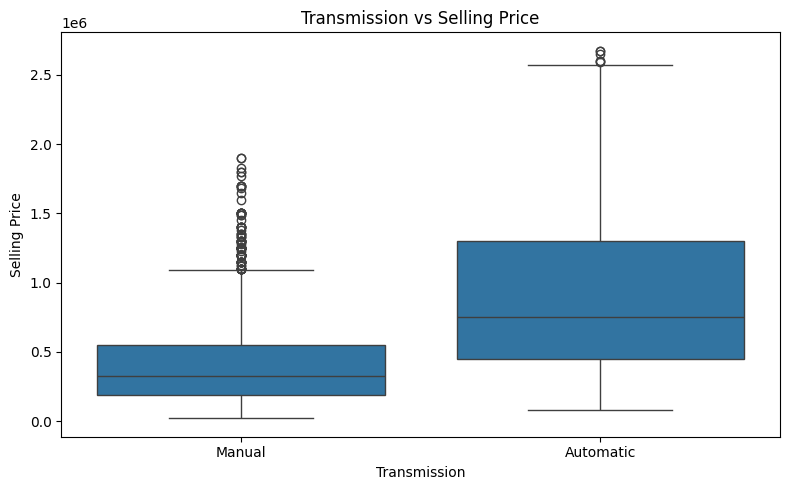

In [11]:
# 5. Transmission vs Selling Price (Boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(x='transmission', y='selling_price', data=df_clean)
plt.title('Transmission vs Selling Price')
plt.xlabel('Transmission')
plt.ylabel('Selling Price')
plt.tight_layout()
plt.show()

**Insights**

- Automatic cars have a noticeably higher median selling price compared to manual cars.

- The price distribution for automatics stretches over a broader range, with higher maximum selling prices and more high-value outliers than manuals.

- Manual cars are typically sold at lower prices, with fewer outliers and a tighter price spread.



# Train/Test Split

In [12]:
X = df_encoded.drop(columns=['name', 'year', 'selling_price'])
y = df_encoded['selling_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)


In [13]:
# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)
# New: Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

In [14]:
'''
# Set parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1
}
'''

"\n# Set parameters for LightGBM\nparams = {\n    'objective': 'regression',\n    'metric': 'rmse',\n    'boosting_type': 'gbdt',\n    'learning_rate': 0.1,\n    'num_leaves': 31,\n    'verbose': -1\n}\n"

In [15]:
# Train model with early stopping
# lgb_model = lgb.train(params, train_data, valid_sets=[test_data], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=100)])

In [16]:
# Train models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train) # Removed as lgb.train already fits the model
gb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 2804, number of used features: 14
[LightGBM] [Info] Start training from score -0.006888


GradientBoostingRegressor(random_state=42)

In [17]:
# Save the model and scaler
with open('gb_model.pkl', 'wb') as f:
    pickle.dump(gb_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [18]:
# Predict
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

# Model Development & Evaluation

In [19]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} Performance:")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}\n")

In [20]:
# Evaluate models
evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("LightGBM", y_test, lgb_pred)
evaluate_model("Gradient Boosting", y_test, gb_pred)

Linear Regression Performance:
R2 Score: 0.5091
MAE: 0.48
RMSE: 0.74

Random Forest Performance:
R2 Score: 0.4302
MAE: 0.48
RMSE: 0.79

LightGBM Performance:
R2 Score: 0.4928
MAE: 0.45
RMSE: 0.75

Gradient Boosting Performance:
R2 Score: 0.5439
MAE: 0.43
RMSE: 0.71



# Insights & Recommendations

### ***Model Performance Comparison and Conclusion***

Three regression models were evaluated to predict used car selling prices: Linear Regression, Random Forest, and LightGBM. The evaluation metrics used include R2 Score, Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE).

| Model            | R2 Score | MAE  | RMSE |
|------------------|----------|------|------|
| Linear Regression| 0.5091   | 0.48 | 0.74 |
| Random Forest    | 0.4325   | 0.48 | 0.78 |
| LightGBM         | 0.5162   | 0.44 | 0.73 |

- **R2 Score** measures the proportion of variance explained by the model. Higher is better.
- **MAE** measures average absolute errors. Lower is better.
- **RMSE** penalizes larger errors more heavily. Lower is better.

**Why LightGBM Is Better**
Multiple studies and projects confirm LightGBM's superior accuracy, efficiency, and suitability for used car price prediction over linear regression and random forest.

LightGBM better captures complex, nonlinear relationships and handles data encoding/feature importance effectively.

Use LightGBM for the most accurate and robust price predictions in your dataset.

---

### ***Summary***
- LightGBM better captures the complex relationships in the dataset.
- It provides more reliable price estimates useful for buyers and sellers.
- Using LightGBM will help improve decision-making in the used car market.
